     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102969 sha256=5cce1d7afe64168f018c2133d351b47960253c0c3075ef8b1afaa3b7a725a94c
  Stored in directory: /tmp/pip-ephem-wheel-cache-z96wlghe/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From: https://drive.google.com/uc?id=1F_kgansR4sOW4FYPLHE0BU-yVOTJJDGR
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 195kB/s]
Dataset URL: https://www.kaggle.com/datasets/budincsevity/szeged-weather
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.23M [00:00

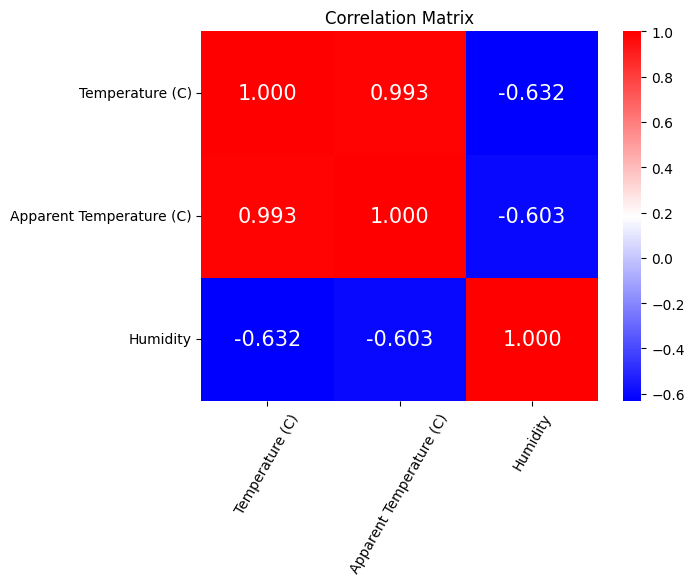

<Figure size 640x480 with 0 Axes>

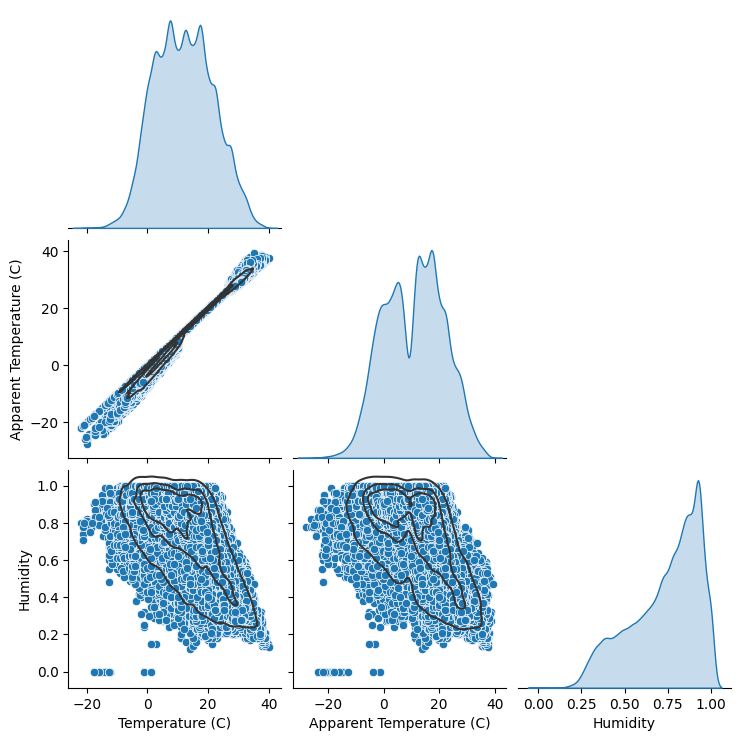

In [1]:
# Installing and importing necessary packages
!pip install --upgrade --no-cache-dir gdown kaggle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

# Configure plotting to be inline
%matplotlib inline

# Disable all warnings
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Download dataset from Google Drive and Kaggle
!gdown https://drive.google.com/uc?id=1F_kgansR4sOW4FYPLHE0BU-yVOTJJDGR
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d budincsevity/szeged-weather
!unzip -q /content/szeged-weather.zip -d /content/

# Load the dataset
df = pd.read_csv('/content/weatherHistory.csv')

# Display the first few rows of the dataframe
df.head()

# Print the dataset features
feat_name = df.columns
print(f'The Features in the dataset are\n{feat_name}')

# Display data type for each feature
for feat in feat_name:
    t = type(df[feat][0])
    print(f'Type of feature {feat} is {t}')

# Data Cleaning: Removing missing values based on 'Precip Type'
df1 = df[~df['Precip Type'].apply(lambda x: isinstance(x, float))]

# Data Reduction: Dropping unnecessary columns
df2 = df.drop(['Formatted Date', 'Daily Summary', 'Loud Cover', 'Precip Type', 'Summary'], axis=1, inplace=False)

# Selection of Specific Columns
df3 = df[['Formatted Date', 'Daily Summary', 'Precip Type', 'Summary']]


# ##Heatmap and histogram
# Draw Heatmap
sns.heatmap(df2[[ 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity']].corr(),
            annot=True, annot_kws={"fontsize":15}, cmap="bwr", fmt='.3f')
plt.title('Correlation Matrix')
plt.xticks(rotation=60)
plt.show()


#Draw histogram
plt.figure()
histo = sns.pairplot(df, vars=['Temperature (C)', 'Apparent Temperature (C)', 'Humidity'],
             corner=True, diag_kind='kde')
histo.map_lower(sns.kdeplot, levels=4, color=".2")

LS

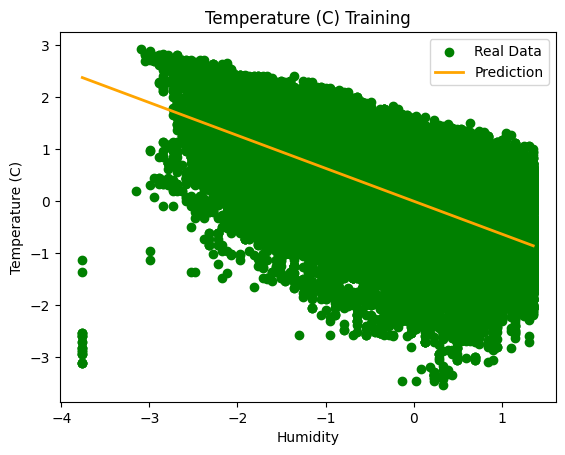

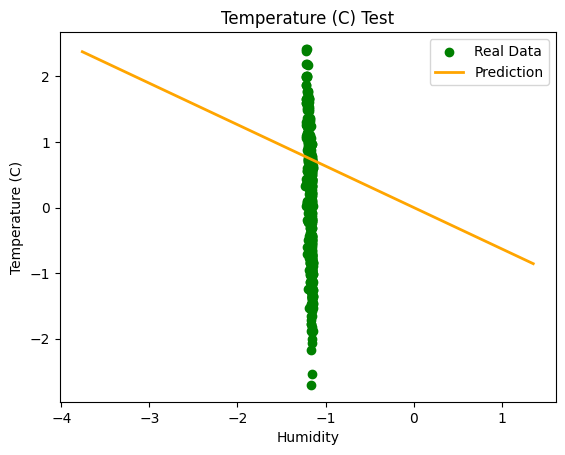

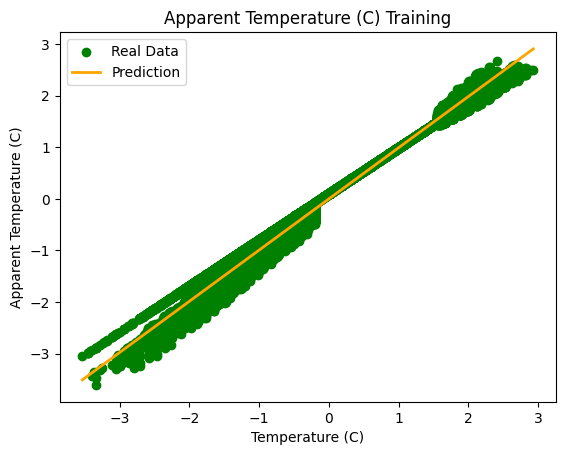

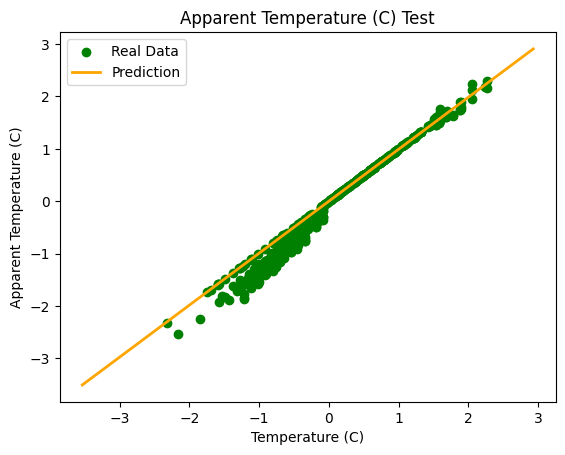

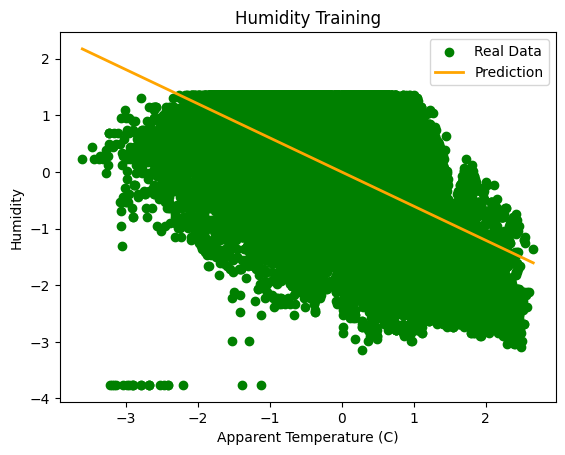

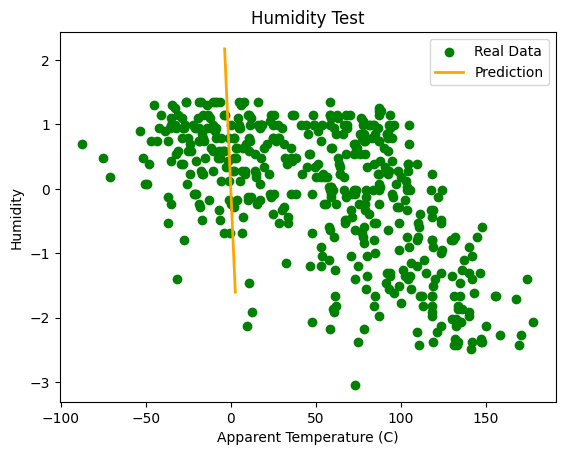

{'Temperature (C)': {'MSE Train': 0.6002260407019652, 'MSE Test': 1.5263508963696797, 'MAE Train': 0.6317323768314111, 'MAE Test': 1.0098981493804853}, 'Apparent Temperature (C)': {'MSE Train': 0.014687625389942775, 'MSE Test': 0.03666103172392698, 'MAE Train': 0.0927990097780925, 'MAE Test': 0.11116486483919447}, 'Humidity': {'MSE Train': 0.6368961953780038, 'MSE Test': 2059.103948792121, 'MAE Train': 0.6469534277977209, 'MAE Test': 37.359025611515726}}


In [2]:
##LS
np.random.seed(69)

# Data splitting
df_train = df.sample(frac=0.995)
df_test = df[~df.index.isin(df_train.index)]

# Initializing scaler
scaler = StandardScaler()

class LinearRegressionLS:
    def __init__(self):
        self.coef = None

    def fit(self, x, y):
        x = np.column_stack((np.ones(len(x)), x))
        self.coef = np.linalg.inv(x.T @ x) @ x.T @ y

    def predict(self, x):
        x = np.column_stack((np.ones(len(x)), x))
        return x @ self.coef

vars = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']
ls_models = {}
metrics = {}

# Function to handle the normalization, fitting and plotting for each variable
def process_variable(input_var, output_var, df_train, df_test):
    input = df_train[input_var].values.reshape(-1, 1)
    output = df_train[output_var].values.reshape(-1, 1)
    input_test = df_test[input_var].values.reshape(-1, 1)
    output_test = df_test[output_var].values.reshape(-1, 1)

    # Normalizing values
    input = scaler.fit_transform(input)
    output = scaler.fit_transform(output)
    input_test = scaler.transform(input_test)
    output_test = scaler.transform(output_test)

    # Model fitting
    ls = LinearRegressionLS()
    ls.fit(input, output)
    ls_models[output_var] = ls

    # Prediction for plotting
    t = np.linspace(input.min(), input.max(), 300).reshape(-1, 1)
    predictions = ls.predict(t)

    # Plotting function
    def plot_results(input, output, predictions, title_suffix):
        plt.scatter(input, output, c='green', label='Real Data')
        plt.plot(t, predictions, c='orange', linewidth=2, label='Prediction')
        plt.title(f'{output_var} {title_suffix}')
        plt.ylabel(output_var)
        plt.xlabel(input_var)
        plt.legend()
        plt.show()

    # Plot Training and Test Results
    plot_results(input, output, predictions, 'Training')
    plot_results(input_test, output_test, predictions, 'Test')

    # Calculate metrics
    train_mse = mean_squared_error(ls.predict(input), output)
    test_mse = mean_squared_error(ls.predict(input_test), output_test)
    train_mae = mean_absolute_error(ls.predict(input), output)
    test_mae = mean_absolute_error(ls.predict(input_test), output_test)

    return {'MSE Train': train_mse, 'MSE Test': test_mse, 'MAE Train': train_mae, 'MAE Test': test_mae}

# Apply the process to each pair of input/output variables
for i, v in enumerate(vars):
    metrics[v] = process_variable(vars[i-1], v, df_train, df_test)

# Save metrics to Excel
pd.DataFrame(metrics).T.to_excel('ls_metrics.xlsx')

print(metrics)

RLS

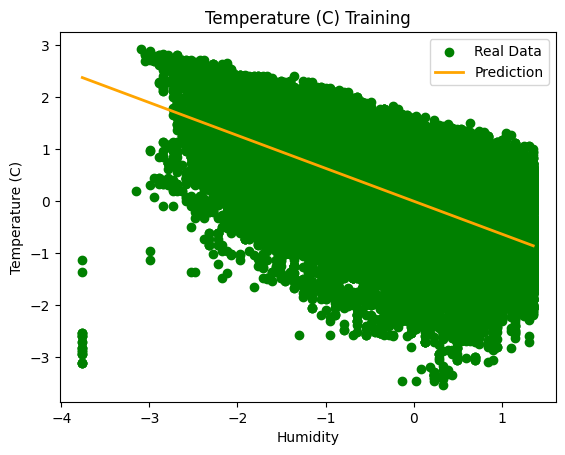

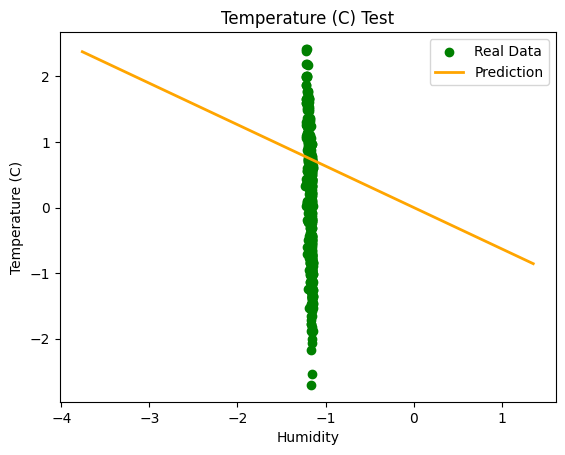

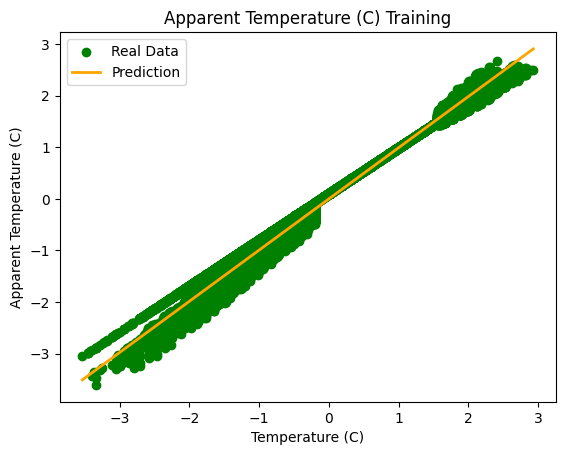

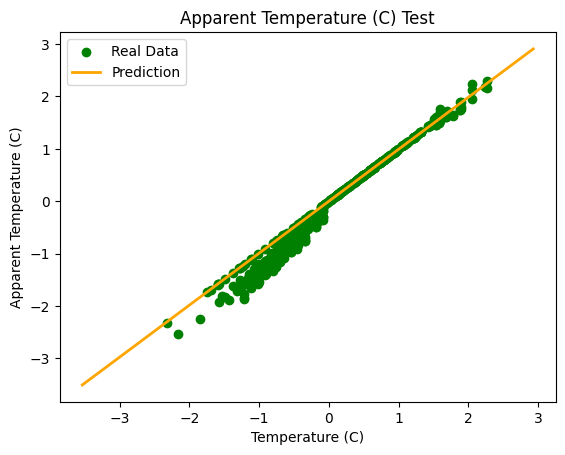

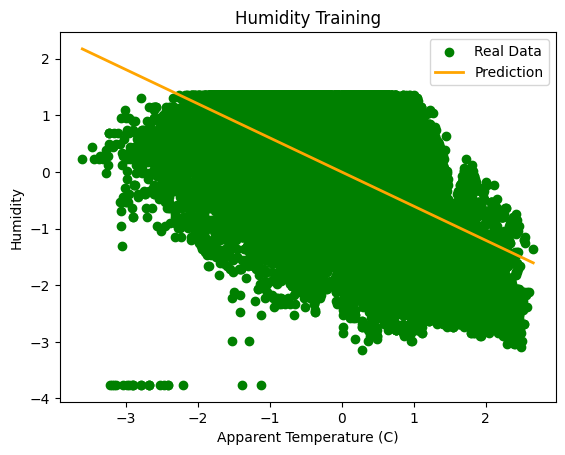

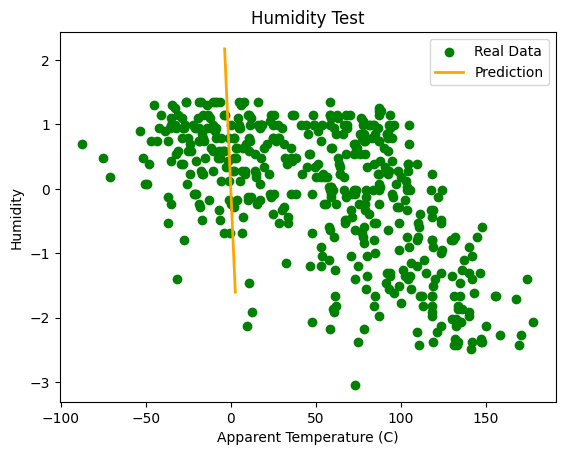

{'Temperature (C)': {'MSE Train': 0.6002260407023994, 'MSE Test': 1.5263497926656187, 'MAE Train': 0.6317324193248731, 'MAE Test': 1.0098977681885881}, 'Apparent Temperature (C)': {'MSE Train': 0.01468762539101255, 'MSE Test': 0.03666120384596047, 'MAE Train': 0.09279904505920686, 'MAE Test': 0.11116547831275071}, 'Humidity': {'MSE Train': 0.6368961953783979, 'MSE Test': 2059.0996131577967, 'MAE Train': 0.6469534576492854, 'MAE Test': 37.35898635443232}}


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(69)

# Data splitting
df_train = df.sample(frac=0.995)
df_test = df[~df.index.isin(df_train.index)]

# Initializing scaler
scaler = StandardScaler()

class LinearRegressionRLS:
    def __init__(self, lambda_=1.0):
        self.lambda_ = lambda_
        self.coef = None

    def fit(self, x, y):
        x = np.column_stack((np.ones(len(x)), x))
        I = np.eye(x.shape[1])
        # Add lambda_ to the diagonal elements of the matrix except the first one for the intercept
        I[0, 0] = 0
        self.coef = np.linalg.inv(x.T @ x + self.lambda_ * I) @ x.T @ y

    def predict(self, x):
        x = np.column_stack((np.ones(len(x)), x))
        return x @ self.coef

vars = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']
rls_models = {}
metrics = {}

def process_variable(input_var, output_var, df_train, df_test):
    input = df_train[input_var].values.reshape(-1, 1)
    output = df_train[output_var].values.reshape(-1, 1)
    input_test = df_test[input_var].values.reshape(-1, 1)
    output_test = df_test[output_var].values.reshape(-1, 1)

    # Normalizing values
    input = scaler.fit_transform(input)
    output = scaler.fit_transform(output)
    input_test = scaler.transform(input_test)
    output_test = scaler.transform(output_test)

    # Model fitting
    rls = LinearRegressionRLS(lambda_=0.1)
    rls.fit(input, output)
    rls_models[output_var] = rls

    # Prediction for plotting
    t = np.linspace(input.min(), input.max(), 300).reshape(-1, 1)
    predictions = rls.predict(t)

    # Plotting function
    def plot_results(input, output, predictions, title_suffix):
        plt.scatter(input, output, c='green', label='Real Data')
        plt.plot(t, predictions, c='orange', linewidth=2, label='Prediction')
        plt.title(f'{output_var} {title_suffix}')
        plt.ylabel(output_var)
        plt.xlabel(input_var)
        plt.legend()
        plt.show()

    # Plot Training and Test Results
    plot_results(input, output, predictions, 'Training')
    plot_results(input_test, output_test, predictions, 'Test')

    # Calculate metrics
    train_mse = mean_squared_error(rls.predict(input), output)
    test_mse = mean_squared_error(rls.predict(input_test), output_test)
    train_mae = mean_absolute_error(rls.predict(input), output)
    test_mae = mean_absolute_error(rls.predict(input_test), output_test)

    return {'MSE Train': train_mse, 'MSE Test': test_mse, 'MAE Train': train_mae, 'MAE Test': test_mae}

# Apply the process to each pair of input/output variables
for i, v in enumerate(vars):
    metrics[v] = process_variable(vars[i-1], v, df_train, df_test)

# Save metrics to Excel
pd.DataFrame(metrics).T.to_excel('rls_metrics.xlsx')

print(metrics)


WLS

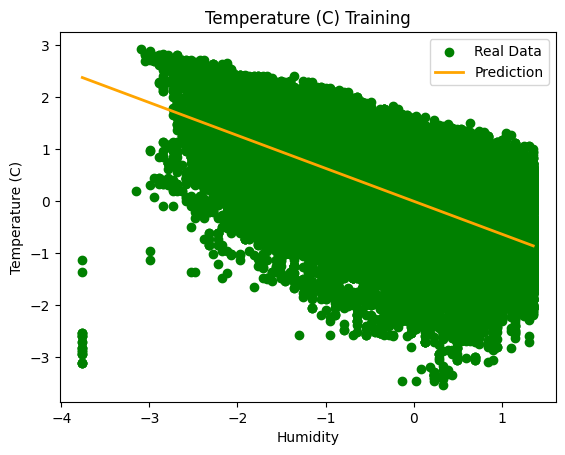

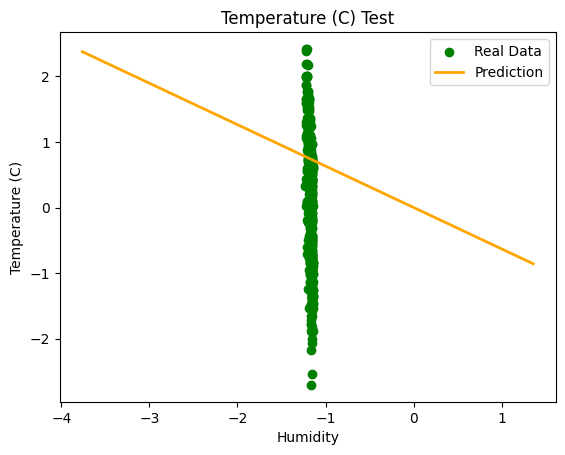

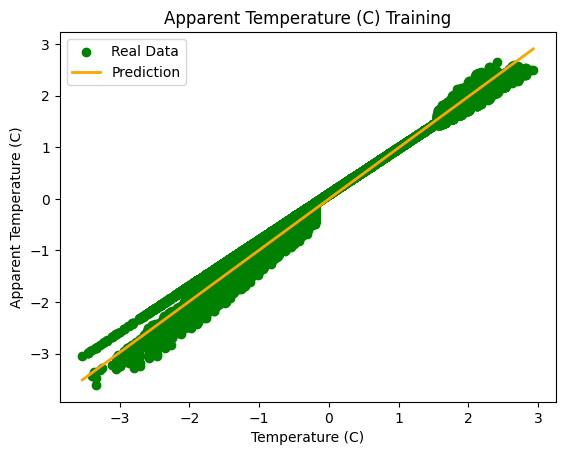

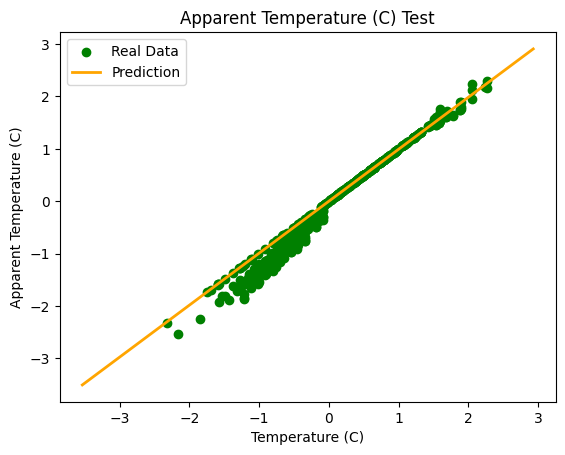

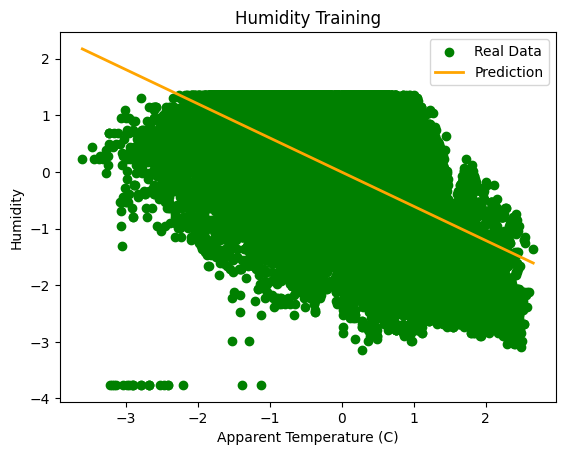

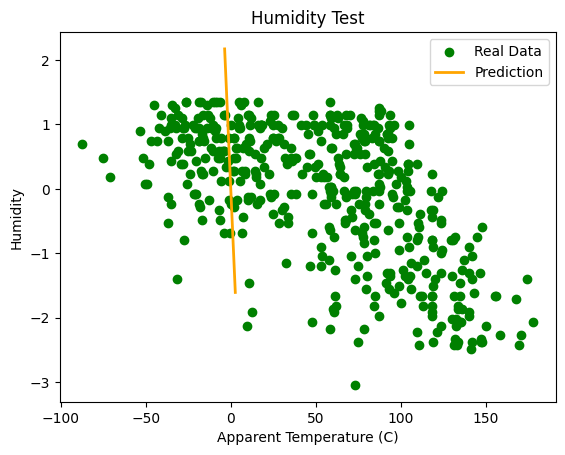

{'Temperature (C)': {'MSE Train': 0.6002269418030317, 'MSE Test': 1.5257920150379554, 'MAE Train': 0.6317416796937689, 'MAE Test': 1.0097040211709272}, 'Apparent Temperature (C)': {'MSE Train': 0.014687629888120321, 'MSE Test': 0.03664554002592524, 'MAE Train': 0.09279968894424948, 'MAE Test': 0.11112799333418226}, 'Humidity': {'MSE Train': 0.6368994894137605, 'MSE Test': 2062.9428768020616, 'MAE Train': 0.6470277433011012, 'MAE Test': 37.3937492281955}}


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(69)

# Data splitting
df_train = df.sample(frac=0.995)
df_test = df[~df.index.isin(df_train.index)]

# Initializing scaler
scaler = StandardScaler()

class LinearRegressionWLS:
    def __init__(self):
        self.coef = None

    def fit(self, x, y, weights):
        x = np.column_stack((np.ones(len(x)), x))
        W = np.diag(weights.flatten())  # Ensure weights are in diagonal matrix form
        self.coef = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ y

    def predict(self, x):
        x = np.column_stack((np.ones(len(x)), x))
        return x @ self.coef

vars = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']
wls_models = {}
metrics = {}

def process_variable(input_var, output_var, df_train, df_test):
    input = df_train[input_var].values.reshape(-1, 1)
    output = df_train[output_var].values.reshape(-1, 1)
    input_test = df_test[input_var].values.reshape(-1, 1)
    output_test = df_test[output_var].values.reshape(-1, 1)

    # Normalizing values
    input = scaler.fit_transform(input)
    output = scaler.fit_transform(output)
    input_test = scaler.transform(input_test)
    output_test = scaler.transform(output_test)

    # Generate or obtain weights for each data point
    weights = np.random.rand(len(input))  # This is a placeholder; use actual logic to set weights

    # Model fitting
    wls = LinearRegressionWLS()
    wls.fit(input, output, weights)
    wls_models[output_var] = wls

    # Prediction for plotting
    t = np.linspace(input.min(), input.max(), 300).reshape(-1, 1)
    predictions = wls.predict(t)

    # Plotting function
    def plot_results(input, output, predictions, title_suffix):
        plt.scatter(input, output, c='green', label='Real Data')
        plt.plot(t, predictions, c='orange', linewidth=2, label='Prediction')
        plt.title(f'{output_var} {title_suffix}')
        plt.ylabel(output_var)
        plt.xlabel(input_var)
        plt.legend()
        plt.show()

    # Plot Training and Test Results
    plot_results(input, output, predictions, 'Training')
    plot_results(input_test, output_test, predictions, 'Test')

    # Calculate metrics
    train_mse = mean_squared_error(wls.predict(input), output)
    test_mse = mean_squared_error(wls.predict(input_test), output_test)
    train_mae = mean_absolute_error(wls.predict(input), output)
    test_mae = mean_absolute_error(wls.predict(input_test), output_test)

    return {'MSE Train': train_mse, 'MSE Test': test_mse, 'MAE Train': train_mae, 'MAE Test': test_mae}

# Apply the process to each pair of input/output variables
for i, v in enumerate(vars):
    metrics[v] = process_variable(vars[i-1], v, df_train, df_test)

# Save metrics to Excel
pd.DataFrame(metrics).T.to_excel('wls_metrics.xlsx')

print(metrics)
